# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

Максимальный балл за задание - 11.
Балл, который ставится в ведомость - min(10,ваш балл).

## Часть 1. Обучение моделей классификации (5 баллов). 

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

A. Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

C. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

D. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

E. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC? 
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from category_encoders.leave_one_out import LeaveOneOutEncoder

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
data = pd.read_csv('telecom_churn.csv')
print(len(data))
data.head()

3333


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})
data['Churn'] = data['Churn'].map({True: 1, False: 0})
data['Churn'].value_counts() / len(data['Churn'])

0    0.855086
1    0.144914
Name: Churn, dtype: float64

Один класс преобладает над другим

**Логистическая регрессия**

In [6]:
data = pd.get_dummies(data, drop_first = True)
s = StandardScaler()
X = data.drop(columns = ['Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [8]:
lr = LogisticRegression(solver = 'liblinear')
cv_lr = cross_validate(lr, X_train, y_train, cv=5, scoring='roc_auc', return_train_score=True)
print('ROC-AUC test:', cv_lr['test_score'].mean())
print('ROC-AUC train:', cv_lr['train_score'].mean())

ROC-AUC test: 0.8005140169071432
ROC-AUC train: 0.8408726269317471


In [11]:
params = {'C' : np.arange(0.1, 2.1, 0.5), 'penalty' : ['l1', 'l2']}
lr = LogisticRegression(solver = 'liblinear', **params)
grid_cv_lr = GridSearchCV(lr, params, scoring = 'roc_auc')
grid_cv_lr.fit(X_train, y_train)
print(grid_cv_lr.best_score_)

0.8115061482202798


In [12]:
clf_lr = grid_cv_lr.best_estimator_
print('Train metrics:\n', classification_report(y_train, clf_lr.predict(X_train)))
print('Test metrics:\n', classification_report(y_test, clf_lr.predict(X_test)))

Train metrics:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      2131
           1       0.64      0.25      0.36       368

    accuracy                           0.87      2499
   macro avg       0.76      0.61      0.64      2499
weighted avg       0.85      0.87      0.84      2499

Test metrics:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       719
           1       0.45      0.19      0.27       115

    accuracy                           0.86       834
   macro avg       0.67      0.58      0.59       834
weighted avg       0.82      0.86      0.83       834



Заметим, что recall у класса один довольно маленький, это из-за дисбаланса класса + того, что мало данных

**Метод опорных векторов**

In [15]:
svm = LinearSVC(max_iter = 10000)
cv_svm = cross_validate(svm, X_train, y_train, cv=5, scoring='roc_auc', return_train_score=True)
print('ROC-AUC test:', cv_svm['test_score'].mean())
print('ROC-AUC train:', cv_svm['train_score'].mean())

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ROC-AUC test: 0.776261461885175
ROC-AUC train: 0.809232328477217


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ROC-AUC test: 0.776261461885175

ROC-AUC train: 0.809232328477217

Это из-за предупреждений может быть плохо, на всякий случай здесь продублировал

In [17]:
params = {'C' : np.arange(0.1, 2.1, 0.5), 'penalty' : ['l1', 'l2']}
svm = LinearSVC(max_iter = 10000, **params)
grid_cv_svm = GridSearchCV(svm, params, scoring = 'roc_auc')
grid_cv_svm.fit(X_train, y_train)
print(grid_cv_svm.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

0.7921164764924156


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7921164764924156 - дублирую результат

In [19]:
clf_svm = grid_cv_svm.best_estimator_
print('Train metrics:\n', classification_report(y_train, clf_svm.predict(X_train)))
print('Test metrics:\n', classification_report(y_test, clf_svm.predict(X_test)))

Train metrics:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      2131
           1       0.65      0.07      0.13       368

    accuracy                           0.86      2499
   macro avg       0.76      0.53      0.52      2499
weighted avg       0.83      0.86      0.81      2499

Test metrics:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       719
           1       0.58      0.06      0.11       115

    accuracy                           0.86       834
   macro avg       0.73      0.53      0.52       834
weighted avg       0.83      0.86      0.81       834



Еще хуже, чем раньше!

**Полиномиальные + удаления**

In [26]:
pipe_lr_poly = Pipeline([('polynomial features', PolynomialFeatures(degree=2)), ('scaler', StandardScaler()), ('model', LogisticRegression()),])
pipe_svm_poly = Pipeline([('polynomial features', PolynomialFeatures(degree=2)), ('scaler', StandardScaler()), ('model',  LinearSVC())])

In [27]:
cv_lr_poly = cross_validate(pipe_lr_poly, X_train, y_train, cv=5, scoring='roc_auc', return_train_score=True)
print('ROC-AUC test:', cv_lr_poly['test_score'].mean())
print('ROC-AUC train:', cv_lr_poly['train_score'].mean())

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

ROC-AUC test: 0.7903037632084042
ROC-AUC train: 0.9995544171135468


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC test: 0.7903037632084042

ROC-AUC train: 0.9995544171135468

Дублирую

In [28]:
cv_svm_poly = cross_validate(pipe_svm_poly, X_train, y_train, cv=5, scoring='roc_auc', return_train_score=True)
print('ROC-AUC test:', cv_svm_poly['test_score'].mean())
print('ROC-AUC train:', cv_svm_poly['train_score'].mean())

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ROC-AUC test: 0.7798089223407809
ROC-AUC train: 0.999708750992341


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ROC-AUC test: 0.7798089223407809

ROC-AUC train: 0.999708750992341

Дублирую

Видно, что есть довольно жесткое переобучение, это неудивительно, т.к. у нас же полиномиальные признаки

<Axes: >

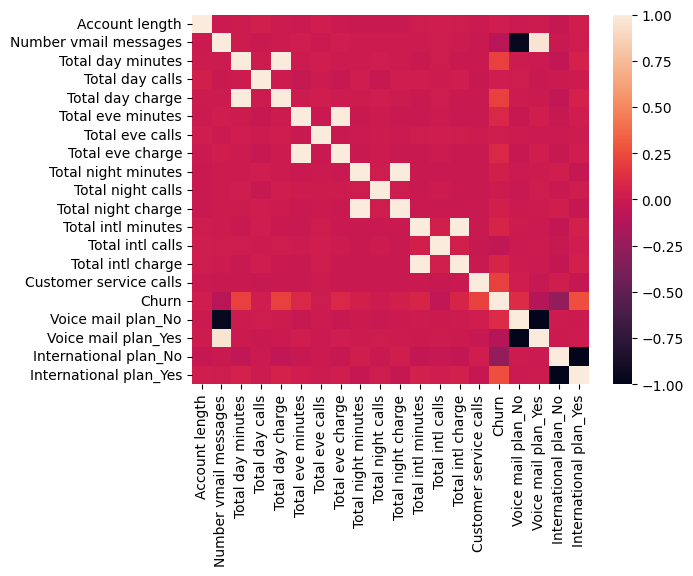

In [29]:
test = data.drop(['State', 'Area code'], axis = 1)
test = pd.get_dummies(test, columns = ['Voice mail plan', 'International plan'])
sns.heatmap(test.corr())

In [25]:
tmp = ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Voice mail plan_Yes']
X_train_new = X_train.drop(tmp, axis = 1)
X_test_new = X_test.drop(tmp, axis = 1)

KeyError: ignored

Чего-то он ругается, у меня не хватает времени исправить. Идея такая: удалить, а потом применить полиномиальные пайплайны (или можно сначала полимноиальные, а потом удалить - но это похоже скорее на переобучение)

Общие выводы: в целом классы несбалансированы и все методы не помогают (если, кончено, не переобучаться), logreg работает чуть лучше, чем другие

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Часть 2. Оценка качества моделей классификации (6 баллов).

**Задание 0 (1 балл)**. Закончите определения, начинающиеся так:

    * accuracy - это доля правильных ответов от всех ответов
    
    * точность (precision) - это доля правильных ответов от общего кол-ва ответов, которые модель отнесла к классу 1
    
    * полнота (recall) - это доля правильных ответов от общего числа класса 1 (в реальности)
    
    * TPR - это доля правильных ответов среди объектов класса 1
    
    
Продолжите определения прямо в этой ячейке.

_______________________________________________________________________________________________

В этой части вы будете работать с данными в задаче скоринга. За работу с этими данными можно получить **5 баллов.**

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные). 
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [30]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [31]:
df.shape

(689, 21)

**Задание 1.** Проверьте target на сбалансированность по классам, сделайте вывод.

In [32]:
print(df[df['target'] == 1].shape[0])
print(df[df['target'] == 0].shape[0])

307
382


Более-менее сбалансировано

**Задание 2.** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [33]:
print(f'Accuracy алгоритма 1 : {accuracy_score(df.target, df.pred1_classes)}')
print(f'Accuracy алгоритма 2 : {accuracy_score(df.target, df.pred2_classes)}')
print(f'Accuracy алгоритма 3 : {accuracy_score(df.target, df.pred3_classes)}')

Accuracy алгоритма 1 : 0.6618287373004355
Accuracy алгоритма 2 : 0.6719883889695211
Accuracy алгоритма 3 : 0.6400580551523948


**Задание 3.** Теперь вычислите точность и полноту каждого из алгоритмов.

In [34]:
print(f'Recall алгоритма 1 : {recall_score(df.target, df.pred1_classes)}')
print(f'Recall алгоритма 2 : {recall_score(df.target, df.pred2_classes)}')
print(f'Recall алгоритма 3 : {recall_score(df.target, df.pred3_classes)}')

Recall алгоритма 1 : 0.4364820846905538
Recall алгоритма 2 : 0.7296416938110749
Recall алгоритма 3 : 0.3485342019543974


In [35]:
print(f'Precision алгоритма 1 : {precision_score(df.target, df.pred1_classes)}')
print(f'Precision алгоритма 2 : {precision_score(df.target, df.pred2_classes)}')
print(f'Precision алгоритма 3 : {precision_score(df.target, df.pred3_classes)}')

Precision алгоритма 1 : 0.6907216494845361
Precision алгоритма 2 : 0.6103542234332425
Precision алгоритма 3 : 0.6903225806451613


Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4.** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [36]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

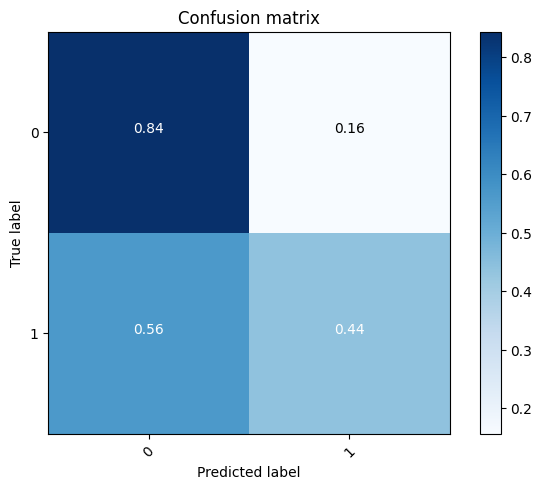

In [37]:
plot_confusion_matrix(confusion_matrix(df.target, df.pred1_classes, normalize = 'true'), [0,1], normalize = True)

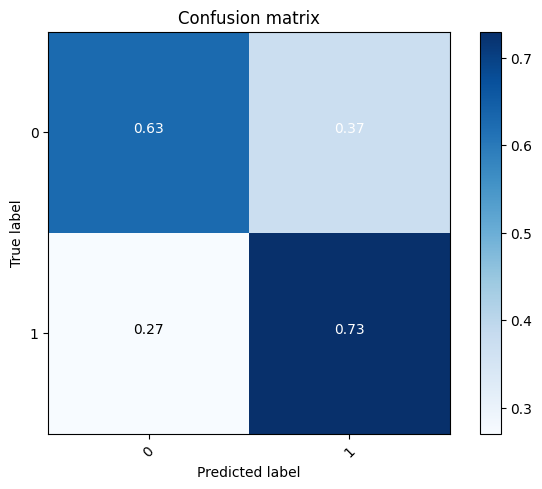

In [39]:
plot_confusion_matrix(confusion_matrix(df.target, df.pred2_classes, normalize = 'true'), [0,1], normalize = True)

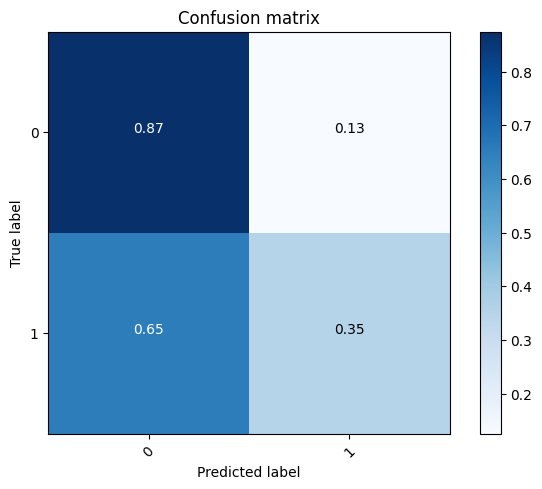

In [40]:
plot_confusion_matrix(confusion_matrix(df.target, df.pred3_classes, normalize = 'true'), [0,1], normalize = True)

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5.** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

Задания 5-9 я не успею сделать, но 10 вроде смог

In [ ]:
#your code here

**Задание 6.** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

In [ ]:
#your code here

**Выводы:** здесь напишите, какая модель лучше всего справилась с поставленной задачей.

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги). 
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7.** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65? 

In [ ]:
#your code here

**Задание 8.** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

In [ ]:
#your code here

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9.** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

In [ ]:
#your code here

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [41]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       382
           1       0.69      0.44      0.53       307

    accuracy                           0.66       689
   macro avg       0.67      0.64      0.63       689
weighted avg       0.67      0.66      0.65       689



### Обучим свою модель для предсказания target.

**Задание 10.** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [42]:
X = df.iloc[:, :14]
y = df['target']

clf = LogisticRegression()
scaler = StandardScaler()
scaler.fit_transform(X)
clf.fit(X, y)

y_pred_proba = clf.predict_proba(X)[:, 1]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Я обучил, но 11 не сделаю, т.к. не успел 5-9

**Задание 11.** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [ ]:
#your code here